In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import IPython

---
## Question 1:

Read chapter 4 from Haykin’s book (2nd edition), starting from section 4.1 to 4.6(including 4.6). Summarize or sketch your insights in mind-map or an outline or a summary.

---
## Question 2:

For this task you have to program the back-propogation (BP) for multi layered perceptron (MLP). Design your implementation for general NN with arbitrary many hidden layers. The test case is as follows:  2-2-1 multi layered perceptron (MLP) with sigmoid activation function on XOR data.

In [3]:
class NeuralNetwork():
    """
    3 layer neural network with 1 input layer, 1 hidden layer, 
    1 output layer...
    2-2-1 Neural Network..
    """
    def __init__(self, num_hidden_neurons = 2, learning_rate = 1, epochs = 100000,
                 num_inputs = 3, zero_weight_init = False, epsilon= 1e-10):
        # Layer 0 --> input, Layer 1 --> hidden, Layer 2 --> output
        if zero_weight_init == False:
            np.random.seed(0)
            # weights randomly initialized...
            self.w_layer01 = np.random.rand(num_inputs, num_hidden_neurons)
            self.w_layer12 = np.random.rand(num_hidden_neurons, 1)
        else:
            # weights initialized to zero...
            self.w_layer01 = np.zeros((num_inputs, num_hidden_neurons))
            self.w_layer12 = np.zeros((num_hidden_neurons, 1))
            
        self.num_hidden_neurons = num_hidden_neurons
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epochs = epochs
        
    def non_linearity(self, value, derivative = False):
        if derivative == True: # return slope of sigmoid..
            return value * (1. - value)
        # included to avoid overflow in numpy exponent..
        value = np.array(value, dtype = np.float128)
        value = np.clip( value, -500, 500 )
        # return sigmoid activation value...
        return 1./(1. + np.exp(-value)) 
        
    def train(self, input_array, output_array):
        iteration, prev_delta = 0, 1.
        conv_count = 0
        while(True):
            layer0 = input_array
            layer1_local_field = input_array.dot(self.w_layer01)
            layer1_output = self.non_linearity(layer1_local_field)
            
            layer2_local_field = layer1_output.dot(self.w_layer12)
            layer2_output = self.non_linearity(layer2_local_field)
        
            layer2_error = -(output_array - layer2_output)
            layer2_delta = layer2_error * self.non_linearity(
                layer2_output, derivative = True)
        
            layer1_error = layer2_delta.dot(self.w_layer12.T)
            layer1_delta = layer1_error * self.non_linearity(
                layer1_output, derivative = True)
            
            # update weights based on error and slope of sigmoid...
            self.w_layer12 -= self.learning_rate * (
                layer1_output.T.dot(layer2_delta))
            self.w_layer01 -= self.learning_rate * (
                layer0.T.dot(layer1_delta))
            
            delta = np.mean(np.abs(layer2_delta))
            check_convergence = prev_delta - delta
            training_error = np.mean(np.abs(layer2_error))
            
            if check_convergence < self.epsilon:
                conv_count += 1
            else:
                conv_count = 0
            
            if iteration % 3000 == 0:
                print 'Epoch: ', iteration, '......', 'Training Error: ', (
                    training_error)
            if iteration > self.epochs or conv_count >= 5: # low delta for more than 5 epochs..
                break
            
            prev_delta = delta.copy()
            iteration += 1
                
        # training error at the end of epochs is returned...
        print '-----------------------------------------------------------'
        if iteration > self.epochs:
            print 'Max epochs reached...'
        else:
            print 'Epoch: ', iteration, '......', 'Training Error: ', (
                    training_error)
            print 'Error has converged...'
        print '-----------------------------------------------------------'
        return [training_error, iteration]
                
    def predict(self, input_array, labels= []):
        layer0 = input_array
        layer1_local_field = input_array.dot(self.w_layer01)
        layer1_output = self.non_linearity(layer1_local_field)
        
        layer2_local_field = layer1_output.dot(self.w_layer12)
        layer2_output = self.non_linearity(layer2_local_field)
        
        if labels == []:
            return layer2_output
        else:
            layer2_error = layer2_output - labels
            # average generalization error is returned..
            return np.mean(np.abs(layer2_error))

In [4]:
# XOR..
input_data = np.array([[1., 0., 0.], [1., 0., 1.], [1., 1., 0.], [1., 1., 1.]])
labels = np.array([0., 1., 1., 0.]).reshape(-1, 1)

print input_data.shape
print labels.shape

(4, 3)
(4, 1)


## 2) a) Experiments with initial weights

### i) Train the network with zero initial weights i.e. $w_{ij} = 0$.

In [5]:
network = NeuralNetwork(zero_weight_init= True)
error = network.train(input_data, labels)[0]

Epoch:  0 ...... Training Error:  0.5
-----------------------------------------------------------
Epoch:  5 ...... Training Error:  0.5
Error has converged...
-----------------------------------------------------------


## ii) Train with random initial weights:

In [6]:
network = NeuralNetwork(zero_weight_init= False, epsilon= 1e-10)
error = network.train(input_data, labels)[0]

Epoch:  0 ...... Training Error:  0.497687854474
-----------------------------------------------------------
Epoch:  5 ...... Training Error:  0.499315123545
Error has converged...
-----------------------------------------------------------


In [7]:
network.predict(np.array([1., 0., 0.]))

array([ 0.54133514], dtype=float128)

## Comparision and Comments on convergence:

Weights initialized to zero:

    

Weights initialized to random values:

    
    
---

## b. Experiment with different learning rates e.g. 0.1, 0.3, 0.5, 0.9:

In [8]:
learning_rates = [0.1, 0.3, 0.5, 0.9]
converged_error = []
epochs = []
for rate in learning_rates:
    network = NeuralNetwork(learning_rate=rate)
    result = network.train(input_data, labels)
    converged_error.append(result[0])
    epochs.append(result[1])

print 'Errors after convergence: '
print '[learning_rate, converged error]'
learn_error = np.array(zip(learning_rates, converged_error))
print learn_error
print '-----------------------------------------------------------'
print 'Epochs taken for convergence: '
print '[learning_rate, epochs]'
learn_epoch = np.array(zip(learning_rates, epochs))
print learn_epoch

Epoch:  0 ...... Training Error:  0.497687854474
-----------------------------------------------------------
Epoch:  5 ...... Training Error:  0.497893711585
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.497687854474
-----------------------------------------------------------
Epoch:  5 ...... Training Error:  0.498296545983
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.497687854474
-----------------------------------------------------------
Epoch:  5 ...... Training Error:  0.498659809611
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.497687854474
-----------------------------------------------------------
Epoch:  5 ...... Training Error:  0.499213048609
Error has converged...
-----------------------------------------------------------
Errors after convergence: 
[learning

## Compare the convergence and plot some resulting surfaces:

## Plot:

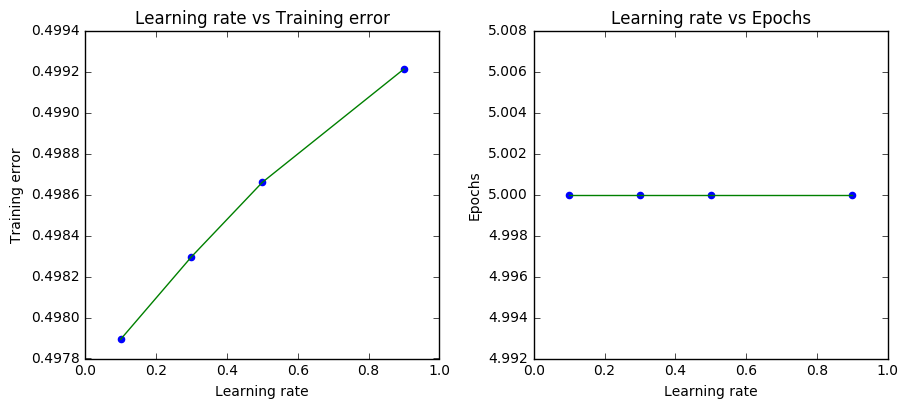

In [9]:
figure = plt.figure(1)
figure.set_figheight(5)
figure.set_figwidth(10)

figure.add_subplot(1, 2, 1)
plt.plot(learn_error[:,0], learn_error[:,1], color = 'g')
plt.xlabel('Learning rate')
plt.ylabel('Training error')
plt.title('Learning rate vs Training error')
plt.scatter(learn_error[:,0], learn_error[:,1], color = 'b')

figure.add_subplot(1, 2, 2)
plt.tight_layout(pad= 4.00)
plt.plot(learn_epoch[:,0], learn_epoch[:,1], color = 'g')
plt.xlabel('Learning rate')
plt.ylabel('Epochs')
plt.title('Learning rate vs Epochs')
plt.scatter(learn_epoch[:,0], learn_epoch[:,1], color = 'b')

plt.show()

## Comparision of convergence:

---

## Question 3:

Investigate the use of back-propagation learning using a sigmoidal nonlinearity to achieve one-to-one mappings, as described here:

For each mapping, do the following:

1. Set up two sets of data, one for network training, and the other for testing.

2. Use the training data set to compute the synaptic weights of the network, assumed to have a single hidden layer.

3. Evaluate the computation accuracy of the network by using the test data. Use a single hidden layer but with a variable number of hidden neurons. Investigate how the network performance is affected by varying the size of the hidden layer.

In [10]:
## Required functions....

def plot_results(hidden_neurons, train_error, test_error, 
                 plot_title, x_axis_lim = (None, None)):
    print 'Training error after convergence: '
    print '[Hidden neurons, converged training error]'
    print np.array(zip(hidden_neurons, train_error))
    print '--------------------------------------------------------------------'
    print 'Test error: '
    print '[Hidden neurons, test error]'
    print np.array(zip(hidden_neurons, test_error))

    plt.plot(hidden_neurons, train_error, color = 'r', label= "Training error")
    plt.plot(hidden_neurons, test_error, color = 'g', label= "Test error")
    plt.scatter(hidden_neurons, train_error, color = 'c', label= "Training error")
    plt.scatter(hidden_neurons, test_error, color = 'm', label= "Test error")
    plt.xlabel('Number of Hidden Neurons')
    plt.ylabel('Error')
    plt.title(plot_title)
    plt.xlim(x_axis_lim[0], x_axis_lim[1])
    plt.legend()
    plt.show()

def obtain_performance(x, y, hidden_neurons):
    data = np.hstack((x, y))
    np.random.seed(0)
    np.random.shuffle(data)
    train_data, test_data = np.vsplit(data, [data.shape[0]*8/10])

    train_error = []
    test_error = []

    for number in hidden_neurons:
        network = NeuralNetwork(num_inputs= 1,
                            num_hidden_neurons= number)
        train_error.append(network.train(train_data[:,:-1],
                                     train_data[:,-1:])[0])
        test_error.append(network.predict(test_data[:,:-1],
                                     labels= test_data[:,-1:]))
        
    return train_error, test_error

In [11]:
hidden_neurons = [1, 2, 3, 4, 5]

## 1) Reciprocal 
$$F(x) = \frac{1}{x}; 1<= x <=100$$

Epoch:  0 ...... Training Error:  0.621064923263
-----------------------------------------------------------
Epoch:  6 ...... Training Error:  0.0580378209043
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.706512351766
-----------------------------------------------------------
Epoch:  6 ...... Training Error:  0.058132167915
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.779557187076
-----------------------------------------------------------
Epoch:  6 ...... Training Error:  0.0581322346546
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.86031985278
-----------------------------------------------------------
Epoch:  6 ...... Training Error:  0.0581321191937
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  

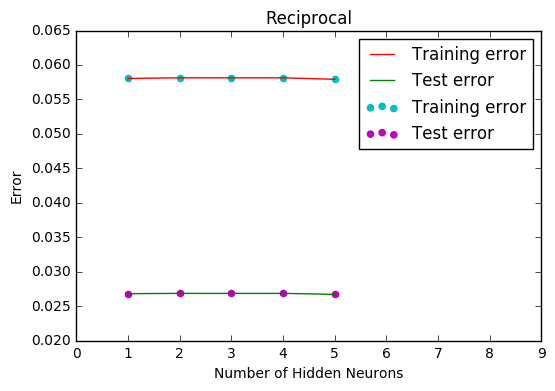

In [13]:
reciprocal_x = np.arange(1, 101, dtype= np.float32).reshape(-1, 1)
reciprocal_y = 1/reciprocal_x
train_error_r, test_error_r = obtain_performance(
    reciprocal_x, reciprocal_y, hidden_neurons)
plot_results(hidden_neurons, train_error_r, test_error_r,
             'Reciprocal',  x_axis_lim= (0, 9))

## 2) Log_10
$$F(x) = log_{10}x; 1<= x <=10$$

Epoch:  0 ...... Training Error:  0.201518897029
-----------------------------------------------------------
Epoch:  112 ...... Training Error:  0.179170017056
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.190483272365
-----------------------------------------------------------
Epoch:  83 ...... Training Error:  0.179170016916
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.188757062427
-----------------------------------------------------------
Epoch:  303 ...... Training Error:  0.179170022807
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.210063794293
-----------------------------------------------------------
Epoch:  317 ...... Training Error:  0.14745779278
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Erro

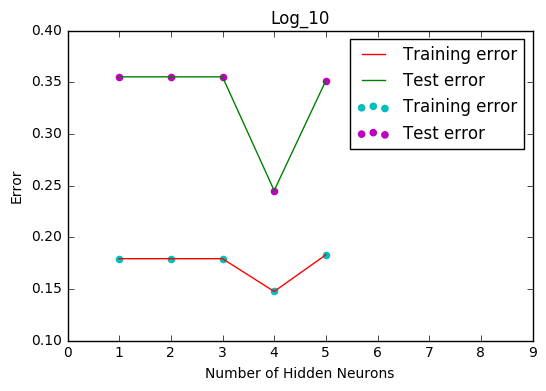

In [14]:
log_x = np.arange(1, 11, dtype= np.float32).reshape(-1, 1)
log_y = np.log10(log_x)
train_error_l, test_error_l = obtain_performance(
    log_x, log_y, hidden_neurons)
plot_results(hidden_neurons, train_error_l, test_error_l,
             'Log_10', x_axis_lim= (0, 9))

## 3) Exponential 
$$F(x) = exp(-x); 1<= x <=10$$

Epoch:  0 ...... Training Error:  0.632697173157
Epoch:  3000 ...... Training Error:  0.0251117162065
-----------------------------------------------------------
Epoch:  3443 ...... Training Error:  0.0251105914223
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.718672338289
-----------------------------------------------------------
Epoch:  2127 ...... Training Error:  0.025110332567
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.791745135003
-----------------------------------------------------------
Epoch:  1797 ...... Training Error:  0.0251102801961
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.875751033438
-----------------------------------------------------------
Epoch:  1667 ...... Training Error:  0.0251103026866
Error has converged...
----------------------------

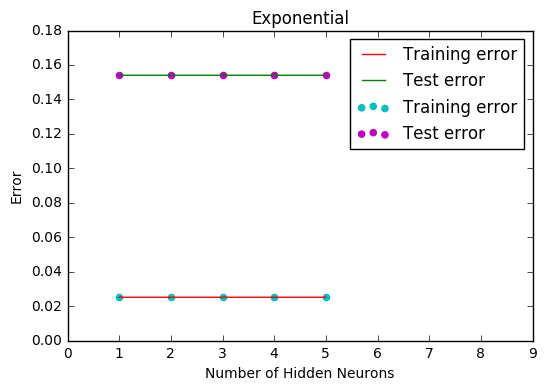

In [16]:
exp_x = np.arange(1, 11, dtype= np.float32).reshape(-1, 1)
exp_y = np.exp(-exp_x)
train_error_e, test_error_e = obtain_performance(
    exp_x, exp_y, hidden_neurons)
plot_results(hidden_neurons, train_error_e, test_error_e, 
             'Exponential',  x_axis_lim= (0, 9))

## 4) Sinusoid 
$$F(x) = sin(x); 0<= x <=\frac{\pi}{2}$$

Epoch:  0 ...... Training Error:  0.255618751934
-----------------------------------------------------------
Epoch:  33 ...... Training Error:  0.233476679606
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.241525507575
-----------------------------------------------------------
Epoch:  548 ...... Training Error:  0.0495867840506
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.237522514536
-----------------------------------------------------------
Epoch:  1154 ...... Training Error:  0.0210461882992
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.249246379747
-----------------------------------------------------------
Epoch:  501 ...... Training Error:  0.0227568269918
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training

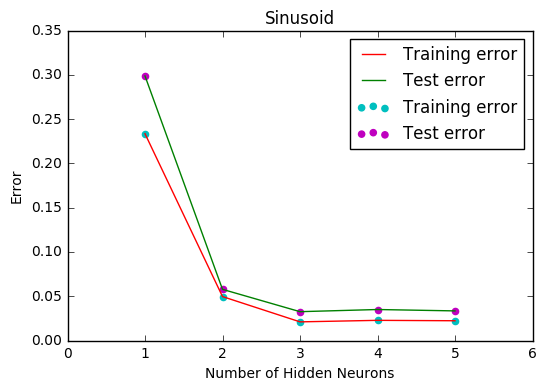

In [17]:
sin_x = np.linspace(0, np.pi/2, dtype= np.float32).reshape(-1, 1)
sin_y = np.sin(sin_x)
train_error_s, test_error_s = obtain_performance(
    sin_x, sin_y, hidden_neurons)
plot_results(hidden_neurons, train_error_s, test_error_s, 'Sinusoid')

---